## CS 6375 - Machine Learning Project
### Topic:- Weather Prediction using RNN.
### Team members:- Aarushi Nagpure (axn220015), Gayatri Mangire (grm210001), Rubina Parveen (rxl220014), Deep Padmani (dmp210005), Harsh Rashmikant Patel (hxp230001), Krittika Paul (kxp230001)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import diff, symbols, exp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

In [ ]:
# Activation function
def Tanh(xVar):
    return np.tanh(xVar)

def Loss(actualsVal, predictionsVal):
    return np.mean(((actualsVal -  predictionsVal))**2)

def derivationOfLoss(actualsVal, predictionsVal):
    return (predictionsVal - actualsVal)

In [ ]:
# class of Neural Network
class NeuralNetwork():
    def __init__(self, data, noOfAttribute, hiddenNodes, noOfOutput, activationFunction, learningRate, Loss, derivationOfLoss) -> None:
        self.data = data
        self.activationFunction = activationFunction
        self.learningRate = learningRate
        self.Loss = Loss
        self.derivationOfLoss = derivationOfLoss

        self.inputs = None
        self.outputs = None
        self.Xtrain = None
        self.Xtest = None
        self.Ytrain = None
        self.Ytest = None

        self.scaler = StandardScaler()

        self.layer_conf = [
                              {"type":"input", "units": noOfAttribute},
                              {"type": "rnn", "hidden": hiddenNodes, "output": noOfOutput}
                          ]

    # Data preprocessing methods
    def normalize(self):
            self.data[self.inputs] = self.scaler.fit_transform(data[self.inputs])
            self.data[self.outputs] = self.scaler.fit_transform(data[self.outputs])


    def printCorrelationMatrix(self):
            # Cleaning the data
            self.dataCleaning()
            # establishing a relationship between each characteristic
            matrixOfCorrelation = self.data.corr()
            plt.figure(figsize=(9, 9))
            sns.heatmap(matrixOfCorrelation, annot=True, cmap="coolwarm", fmt='.2f', square=True)
            plt.title('Correlation Matrix of Numeric Features')
            plt.show()


    def dataCleaning(self):
            print("Null values exist") if self.data.isna().any().any() else print("Not a single null value exists")
            self.data['date'] = pd.to_datetime(self.data['date'], dayfirst=True)

            self.data['year'] = self.data['date'].dt.year
            self.data['month'] = self.data['date'].dt.month
            self.data['day'] = self.data['date'].dt.day
            self.data = self.data.drop("date", axis=1)


            # Drop the original categorical column
            self.data.drop('weather', axis=1, inplace=True)
            self.data.drop('tmax_tomorrow', axis=1, inplace=True)

            self.inputs = ['precipitation', 'temp_max', 'temp_min', 'wind', 'year','month','day']
            self.outputs = ['tmax_tomorrow']

            self.normalize()


     # The entire set of data will be divided into training and testing sets using this function.
    def split(self, percentageOfSplit):
            np.random.seed(0)
            train_size = int(percentageOfSplit * len(self.data))
            self.Xtrain = self.data[self.inputs].iloc[:train_size].to_numpy()
            self.Ytrain = self.data[self.outputs].iloc[:train_size].to_numpy()
            self.Xtest = self.data[self.inputs].iloc[train_size:].to_numpy()
            self.Ytest = self.data[self.outputs].iloc[train_size:].to_numpy()

    def init_params(self):
            layers = []
            for i in range(1, len(self.layer_conf)):
                np.random.seed(0)
                k = 1/math.sqrt(self.layer_conf[i]["hidden"])
                i_weight = np.random.rand(self.layer_conf[i-1]["units"], self.layer_conf[i]["hidden"]) * 2 * k - k

                h_weight = np.random.rand(self.layer_conf[i]["hidden"], self.layer_conf[i]["hidden"]) * 2 * k - k
                h_bias = np.random.rand(1, self.layer_conf[i]["hidden"]) * 2 * k - k

                o_weight = np.random.rand(self.layer_conf[i]["hidden"], self.layer_conf[i]["output"]) * 2 * k - k
                o_bias = np.random.rand(1, self.layer_conf[i]["output"]) * 2 * k - k

                layers.append(
                    [i_weight, h_weight, h_bias, o_weight, o_bias]
                )
            return layers

    def forwardPass(self, x, layers):
            hiddens = []
            outputs = []
            for i in range(len(layers)):
                i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
                hidden = np.zeros((x.shape[0], i_weight.shape[1]))
                output = np.zeros((x.shape[0], o_weight.shape[1]))
                for j in range(x.shape[0]):
                    input_x = x[j,:][np.newaxis,:] @ i_weight
                    hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
                    # Activation.  tanh avoids outputs getting larger and larger.
                    hidden_x = self.activationFunction(hidden_x)
                    # Store hidden for use in backprop
                    hidden[j,:] = hidden_x

                    # Output layer
                    output_x = hidden_x @ o_weight + o_bias
                    output[j,:] = output_x
                hiddens.append(hidden)
                outputs.append(output)
            return hiddens, outputs[-1]

    def predict(self, dataInput, layers):
        _,predictions = self.forwardPass(dataInput,layers)
        return predictions

    def backwardPass(self, layers, x, lr, grad, hiddens):
            for i in range(len(layers)):
                i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
                hidden = hiddens[i]
                next_h_grad = None
                i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

                for j in range(x.shape[0] - 1, -1, -1):
                    # Add newaxis in the first dimension
                    out_grad = grad[j,:][np.newaxis, :]

                    # Output updates
                    # np.newaxis creates a size 1 axis, in this case transposing matrix
                    o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
                    o_bias_grad += out_grad

                    # Propagate gradient to hidden unit
                    h_grad = out_grad @ o_weight.T

                    if j < x.shape[0] - 1:
                        # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                        hh_grad = next_h_grad @ h_weight.T
                        # Add the gradients together to combine output contribution and hidden contribution
                        h_grad += hh_grad

                    # Pull the gradient across the current hidden nonlinearity
                    # derivative of tanh is 1 - tanh(x) ** 2
                    # So we take the output of tanh (next hidden state), and plug in
                    tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

                    # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
                    # Effect is to pull value across nonlinearity
                    h_grad = np.multiply(h_grad, tanh_deriv)

                    # Store to compute h grad for previous sequence position
                    next_h_grad = h_grad.copy()

                    # If we're not at the very beginning
                    if j > 0:
                        h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                        h_bias_grad += h_grad

                    i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

                # Normalize lr by number of sequence elements
                lr = lr / x.shape[0]
                i_weight -= i_weight_grad * lr
                h_weight -= h_weight_grad * lr
                h_bias -= h_bias_grad * lr
                o_weight -= o_weight_grad * lr
                o_bias -= o_bias_grad * lr
                layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
            return layers

    def train(self, epochs):
        layers = self.init_params()


        # Splitting the data into training and testing
        self.split(percentageOfSplit=0.8)


        for epoch in range(epochs):
            sequence_len = 6
            epoch_loss = 0
            for j in range(self.Xtrain.shape[0] - sequence_len):
                seq_x = self.Xtrain[j:(j+sequence_len),]
                seq_y = self.Ytrain[j:(j+sequence_len),]
                hiddens, outputs = self.forwardPass(seq_x, layers)
                grad = derivationOfLoss(seq_y, outputs)
                params = self.backwardPass(layers, seq_x, self.learningRate, grad, hiddens)
                epoch_loss += Loss(seq_y, outputs)

            if epoch % 50 == 0:
                sequence_len = 6
                test_loss = 0
                for j in range(self.Xtest.shape[0] - sequence_len):
                    seq_x = self.Xtest[j:(j+sequence_len),]
                    seq_y = self.Ytest[j:(j+sequence_len),]
                    _, outputs = self.forwardPass(seq_x, layers)
                    test_loss += Loss(seq_y, outputs)

      #Model Evaluation:
        predictionsOftraining = self.predict(self.Xtrain,layers)
        print("The following are the train scores:")
        print(f"Mean Square Error: {mean_squared_error(self.Ytrain, predictionsOftraining)}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.Ytrain, predictionsOftraining)}")
        print(f"R square Fit:  {r2_score(self.Ytrain, predictionsOftraining)}")
        print(f"Loss: {epoch_loss / len(self.Xtrain)}")

        print("\nThe following are the Test scores:")
        predictionsOftesting = self.predict(self.Xtest,layers)
        print(f"Mean Square Error: {mean_squared_error(self.Ytest, predictionsOftesting)}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.Ytest, predictionsOftesting)}")
        print(f"R square Fit:  {r2_score(self.Ytest, predictionsOftesting)}")
        print(f"Loss: {test_loss / len(self.Xtest)}")

    # Scatter Plot of Training Data
        plt.figure(figsize=(7, 7))
        plt.scatter(self.Ytrain, predictionsOftraining, color='blue', marker='o')
        # Diagonal line represents true label
        plt.plot([self.Ytrain.min(), self.Ytrain.max()], [self.Ytrain.min(), self.Ytrain.max()], 'k-', lw = 1)
        plt.xlabel('True Label')
        plt.ylabel('Prediction')
        plt.title('Scatter plot of True Label vs. Prediction for Training Data')
        plt.grid(True)
        plt.show()

    # Scatter Plot of Testing Data
        plt.figure(figsize=(7, 7))
        plt.scatter(self.Ytest, predictionsOftesting, color='blue', marker='o')
        # Diagonal line represents true label
        plt.plot([self.Ytest.min(), self.Ytest.max()], [self.Ytest.min(), self.Ytest.max()], 'k-', lw = 1)
        plt.xlabel('True Label')
        plt.ylabel('Prediction')
        plt.title('Scatter plot of True Label vs. Prediction for Test Data')
        plt.grid(True)
        plt.show()



Not a single null value exists


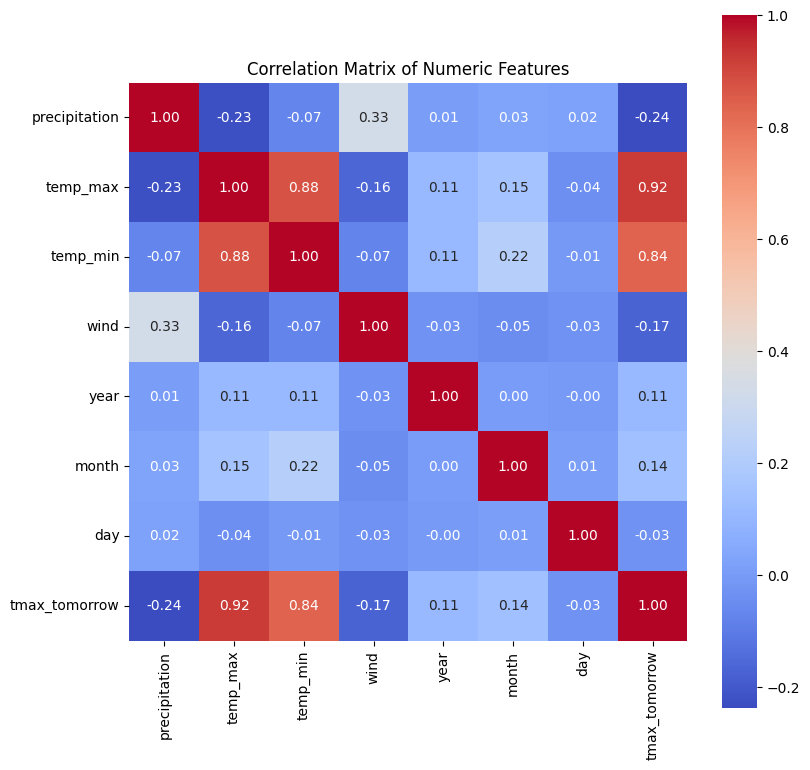

The following are the train scores:
Mean Square Error: 0.13417018359929475
Mean Absolute Error: 0.2909640310832649
R square Fit:  0.8605852026935168
Loss: 0.13556042020585618

The following are the Test scores:
Mean Square Error: 0.16211580177482557
Mean Absolute Error: 0.3171236322602114
R square Fit:  0.841460320129567
Loss: 0.1642548731263084


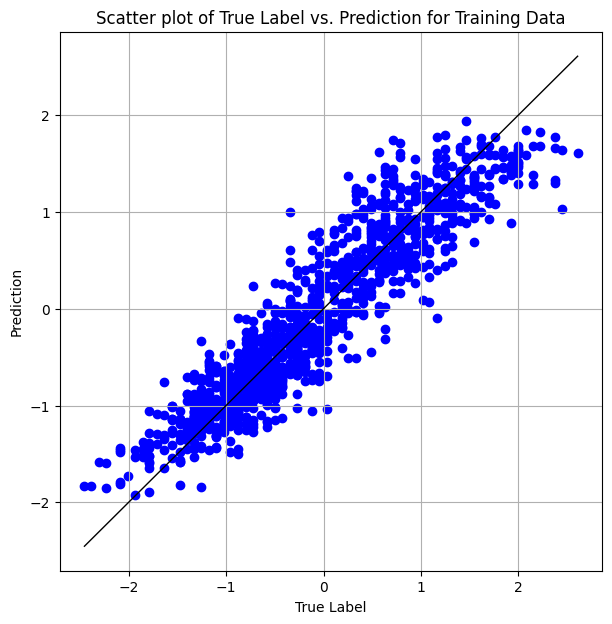

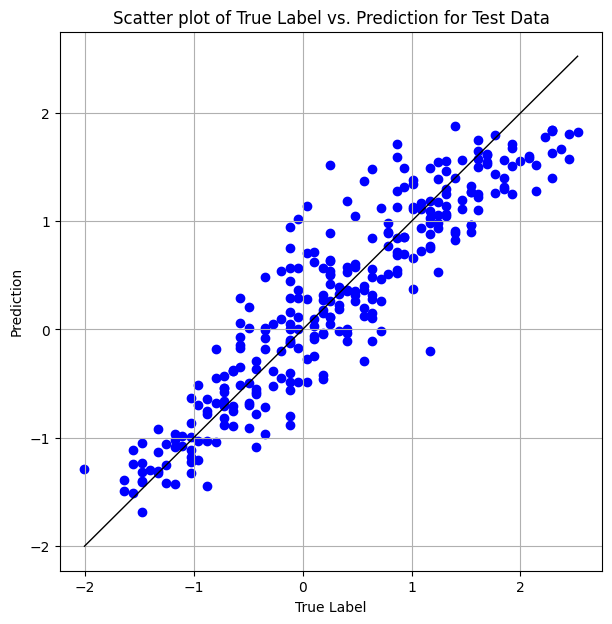

In [ ]:
if __name__ == "__main__":
    data = pd.read_csv("https://raw.githubusercontent.com/deeppadmani/Datasets/main/weather/seattle-weather.csv")
    data = data.ffill()

    NeuralNet = NeuralNetwork(data=data, hiddenNodes=14, noOfAttribute=7, noOfOutput=1, activationFunction=Tanh, learningRate=1e-5, Loss=Loss, derivationOfLoss=derivationOfLoss)
    NeuralNet.printCorrelationMatrix()
    NeuralNet.train(2000)

